# **실습 문제**
* 동일한 데이터셋을 활용하여 lightgbm classifier 구축 및 해석 진행

###  **0. 필요한 라이브러리 불러오기**


In [3]:
!pip install eli5
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=79ee3a0e6ffa5b462b7f514bcd8efc1efb6a320d47cb48333f7730652e6e2686
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=561bf981741dca8fc101af1b769edec5e5826b1f3537c407ba1c3f4423a8b3bc
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import * #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
import shap #for SHAP values
shap.initjs()
import sklearn.inspection
import lime
from lime import lime_tabular
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

###  **1. 데이터 불러오기**

In [9]:
dt = pd.read_csv("/content/sample_data/dataset_heart.csv")
dt.head(10)

age  sex   chest pain type  resting blood pressure  serum cholestoral  \
0   70     1                4                     130                322   
1   67     0                3                     115                564   
2   57     1                2                     124                261   
3   64     1                4                     128                263   
4   74     0                2                     120                269   
5   65     1                4                     120                177   
6   56     1                3                     130                256   
7   59     1                4                     110                239   
8   60     1                4                     140                293   
9   63     0                4                     150                407   

   fasting blood sugar  resting electrocardiographic results  max heart rate  \
0                    0                                     2             109   
1                    0                                     2             160   
2                    0                                     0             141   
3                    0                                     0             105   
4                    0                                     2             121   
5                    0                                     0             140   
6                    1                                     2             142   
7                    0                                     2             142   
8                    0                                     2             170   
9                    0                                     2             154   

   exercise induced angina  oldpeak  ST segment  major vessels  thal  \
0                        0      2.4           2              3     3   
1                        0      1.6           2              0     7   
2                        0      0.3           1              0     7   
3                        1      0.2           2              1     7   
4                        1      0.2           1              1     3   
5                        0      0.4           1              0     7   
6                        1      0.6           2              1     6   
7                        1      1.2           2              1     7   
8                        0      1.2           2              2     7   
9                        0      4.0           2              3     7   

   heart disease  
0              2  
1              1  
2              2  
3              1  
4              1  
5              1  
6              2  
7              2  
8              2  
9              2


```
  - 1. age       
  - 2. sex       
  - 3. chest pain type  (4 values)       
  - 4. resting blood pressure  
  - 5. serum cholestoral in mg/dl      
  - 6. fasting blood sugar > 120 mg/dl       
  - 7. resting electrocardiographic results  (values 0,1,2)
  - 8. maximum heart rate achieved  
  - 9. exercise induced angina    
  - 10. oldpeak = ST depression induced by exercise relative to rest   
  - 11. the slope of the peak exercise ST segment     
  - 12. number of major vessels (0-3) colored by flourosopy        
  - 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
  - 14. Heart disease(Absence (1) or presence (2) of heart disease)

```




In [10]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [11]:
dt.head(10)

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   70    1                4                     130          322   
1   67    0                3                     115          564   
2   57    1                2                     124          261   
3   64    1                4                     128          263   
4   74    0                2                     120          269   
5   65    1                4                     120          177   
6   56    1                3                     130          256   
7   59    1                4                     110          239   
8   60    1                4                     140          293   
9   63    0                4                     150          407   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                    0         2                      109   
1                    0         2                      160   
2                    0         0                      141   
3                    0         0                      105   
4                    0         2                      121   
5                    0         0                      140   
6                    1         2                      142   
7                    0         2                      142   
8                    0         2                      170   
9                    0         2                      154   

   exercise_induced_angina  st_depression  st_slope  num_major_vessels  \
0                        0            2.4         2                  3   
1                        0            1.6         2                  0   
2                        0            0.3         1                  0   
3                        1            0.2         2                  1   
4                        1            0.2         1                  1   
5                        0            0.4         1                  0   
6                        1            0.6         2                  1   
7                        1            1.2         2                  1   
8                        0            1.2         2                  2   
9                        0            4.0         2                  3   

   thalassemia  target  
0            3       2  
1            7       1  
2            7       2  
3            7       1  
4            3       1  
5            7       1  
6            6       2  
7            7       2  
8            7       2  
9            7       2

In [12]:
dt['target'].unique()

array([2, 1])

###  **2. 모델 학습**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = 0.2, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


((216, 13), (54, 13), (216,), (54,))

####  **3. LightGBM 모델 훈련**

In [ ]:
import lightgbm as lgb

In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 92, number of negative: 124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.425926 -> initscore=-0.298493
[LightGBM] [Info] Start training from score -0.298493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMClassifier()

In [ ]:
y_predict = clf.predict(X_test)
y_pred_quant = clf.predict_proba(X_test)[:, 1]

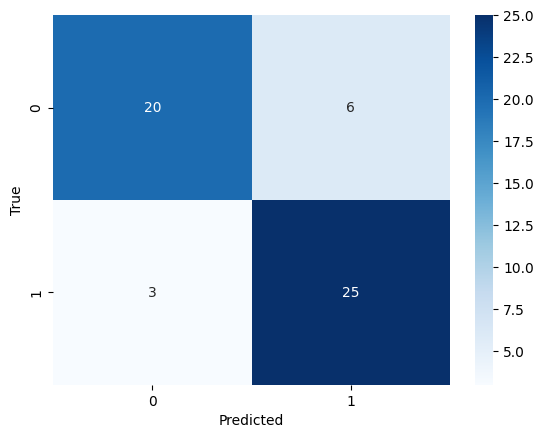

In [ ]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_predict)
print('accuracy_score : ', acc)

pre = precision_score(y_test, y_predict)
print('precision_score : ', pre)

recall = recall_score(y_test, y_predict)
print('recall_score: ', recall)

accuracy_score :  0.8333333333333334
precision_score :  0.8695652173913043
recall_score:  0.7692307692307693


## **4. The Explanation**

###  **4-1. LGBM Classifer feature Importance**

In [ ]:
importance = clf.feature_importances_
feature = X_train.columns
importances = pd.DataFrame()
importances['feature'] = feature
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
importances

feature  importances
0                       age          132
1               cholesterol          120
2   max_heart_rate_achieved          117
3    resting_blood_pressure           74
4             st_depression           67
5           chest_pain_type           55
6         num_major_vessels           52
7               thalassemia           48
8                  rest_ecg           36
9                       sex           30
10                 st_slope           18
11  exercise_induced_angina           11
12      fasting_blood_sugar            0

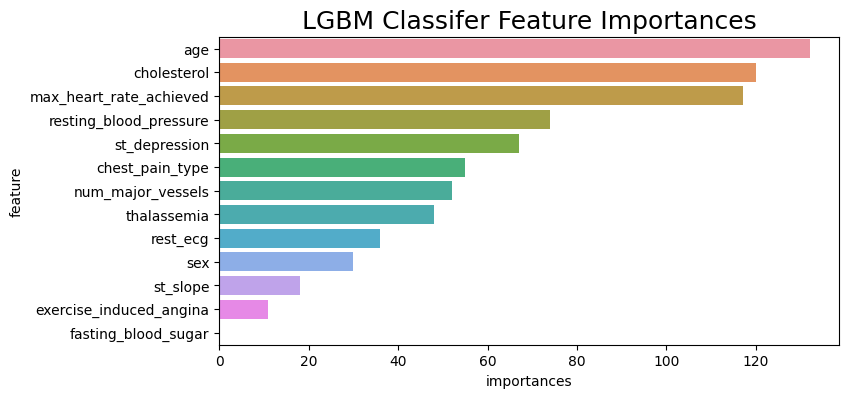

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='importances', y='feature', data=importances)
plt.title('LGBM Classifer Feature Importances', fontsize=18)
plt.show()

###  **4-2. Permutation Importance**

In [ ]:
#column을 무작위로 재정렬하면 결과 데이터가 더 이상 실제 세계에서 관찰되는 것과 더 이상 일치하지 않으므로 예측 정확도가 떨어짐
#모델이 예측에 크게 의존하는 열을 섞으면 모델 정확도가 특히 떨어지는 결과를 도출함
#랜덤 셔플링 후 정확도을 사용하여 감소한 모델 성능을 나타냄
perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

###  **4-3. PDP & ICE**

In [ ]:
feature_names

['age',
 'sex',
 'chest_pain_type',
 'resting_blood_pressure',
 'cholesterol',
 'fasting_blood_sugar',
 'rest_ecg',
 'max_heart_rate_achieved',
 'exercise_induced_angina',
 'st_depression',
 'st_slope',
 'num_major_vessels',
 'thalassemia']

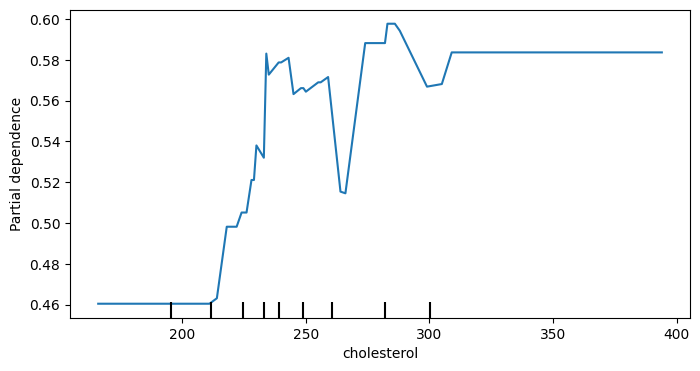

In [ ]:
fig = plt.figure(figsize=(8, 4))
fig.set_facecolor('white')
ax = fig.add_subplot()
feature_name = 'cholesterol'
PartialDependenceDisplay.from_estimator(clf, ## 학습 모델
                                        X_test, ## 의존도 계산시 필요한 데이터
                                        [feature_name], ## 관심 변수
                                        feature_names=feature_names, ## 변수 이름
                                        kind='average', ## average = pdp, ice = ice
                                        ax=ax
                                       )

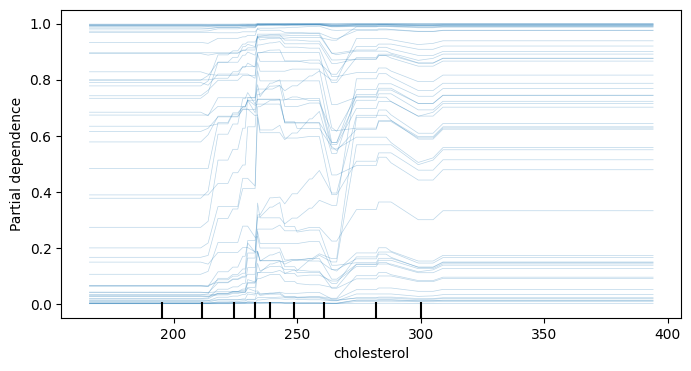

In [ ]:
fig = plt.figure(figsize=(8, 4))
fig.set_facecolor('white')
ax = fig.add_subplot()
feature_name = 'cholesterol'
PartialDependenceDisplay.from_estimator(clf, ## 학습 모델
                                        X_test, ## 의존도 계산시 필요한 데이터
                                        [feature_name], ## 관심 변수
                                        feature_names=feature_names, ## 변수 이름
                                        kind='individual',
                                        ax=ax
                                       )

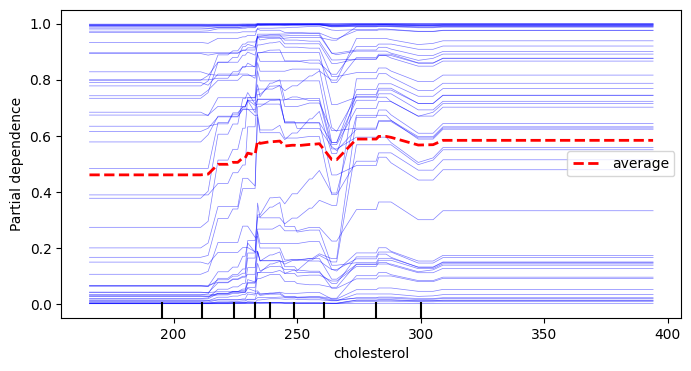

In [ ]:
fig = plt.figure(figsize=(8, 4))
fig.set_facecolor('white')
ax = fig.add_subplot()
feature_name = 'cholesterol'
PartialDependenceDisplay.from_estimator(clf, ## 학습 모델
                                        X_test, ## 의존도 계산시 필요한 데이터
                                        [feature_name], ## 관심 변수
                                        feature_names=feature_names, ## 변수 이름
                                        kind='both',
                                        ice_lines_kw={'color':'blue', 'alpha':0.5}, ## ice 선 스타일
                                        pd_line_kw={'color':'red', 'linewidth':2}, ## pdp 선 스타일
                                        ax=ax
                                       )

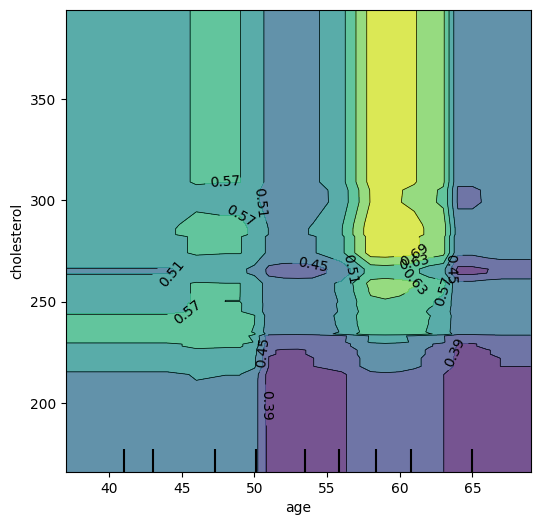

In [ ]:
feature_name = ['age', 'cholesterol']
fig, ax = plt.subplots(figsize=(6, 6))
PartialDependenceDisplay.from_estimator(estimator=clf, X=X_test, features=[feature_name],
                        kind='average',
                        ax=ax);

###  **4-5. SHAP**

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


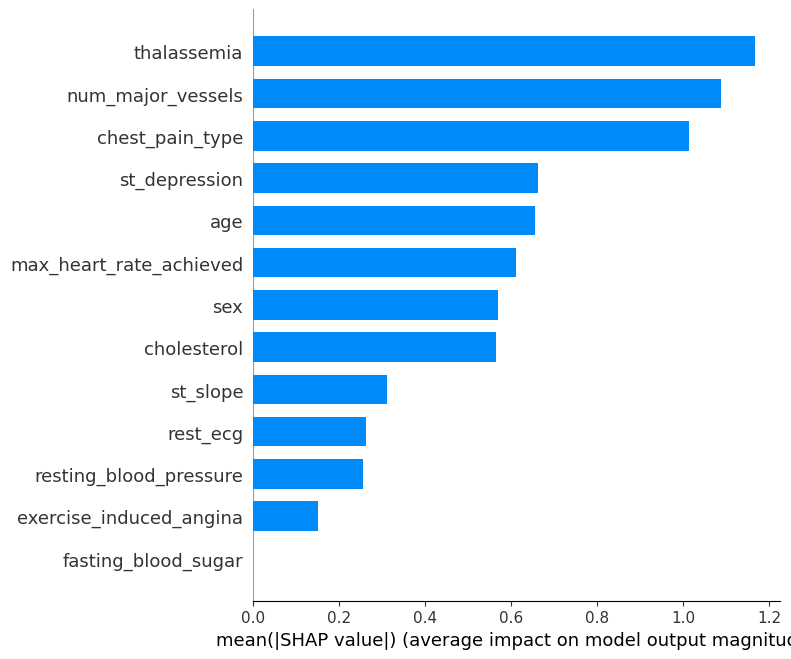

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


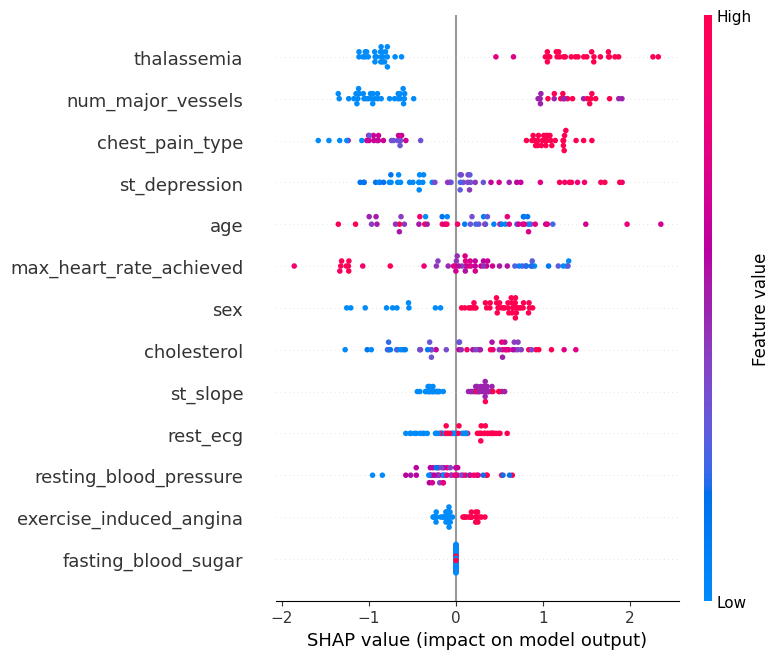

In [ ]:
shap.summary_plot(shap_values[1], X_test)

In [ ]:
def heart_disease_risk_factors_lgbm(model, patient):
    explainer = shap.TreeExplainer(model)
    shap.initjs()
    shap_values = explainer.shap_values(patient)
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [ ]:
data_for_prediction_lgbm = X_test.iloc[1, :].astype(float).values.reshape(1, -1)
heart_disease_risk_factors_lgbm(clf, data_for_prediction_lgbm)

In [ ]:
data_for_prediction_lgbm = X_test.iloc[3,:].astype(float).values.reshape(1, -1)
heart_disease_risk_factors_lgbm(clf, data_for_prediction_lgbm)

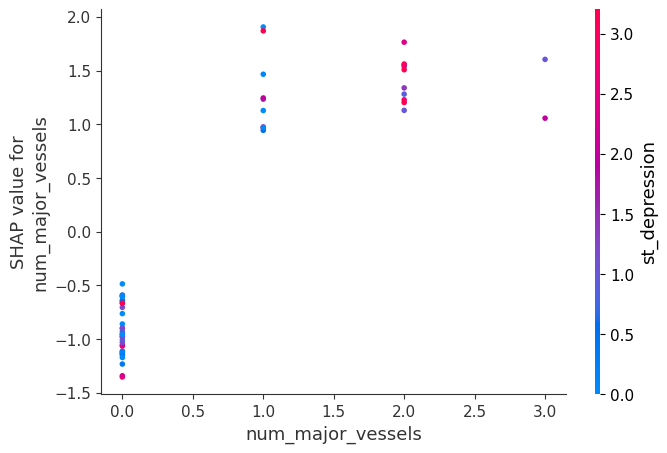

In [ ]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


###  **4-5. LIME**

In [ ]:
# This function will show how a feature is pushing towards 0 or 1
def interpret_with_lime(clf, X_test):
  # New data
  interpretor = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='classification')


  exp = interpretor.explain_instance(
      data_row=X_test.iloc[10],
      predict_fn=clf.predict_proba
  )

  exp.show_in_notebook(show_table=True)

In [ ]:
interpret_with_lime(clf,X_test)